In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from training.utils import utils

1. Filters

In [2]:
device = "cuda:0"
fname = 'WCRR-CNN'
model = utils.load_model(fname, device=device)
model.eval()
model.to(device)
# high accuracy computation of \|W\|
print(" **** Updating the Lipschitz constant **** ")
sn_pm = model.conv_layer.spectral_norm(mode="power_method", n_steps=500)

Multi convolutionnal layer:  {'num_channels': [1, 4, 8, 60], 'size_kernels': [5, 5, 5]}
 **** Updating the Lipschitz constant **** 


view WtW

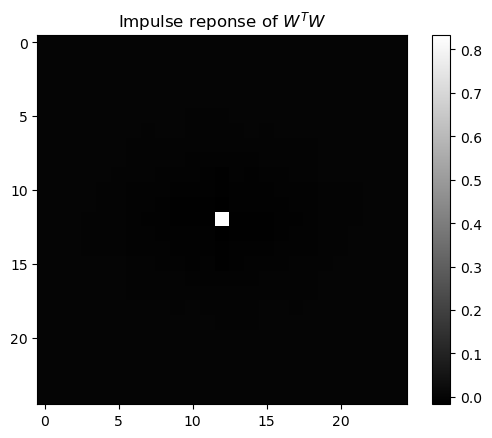

In [3]:
plt.imshow(model.conv_layer.get_kernel_WtW()[0,0].detach().cpu().numpy(), cmap="gray")
plt.title(r'Impulse reponse of $W^T W$')
plt.colorbar()

In [4]:
def get_filter_image(normalize=False):
    kernels = model.conv_layer.get_filters()
    s = kernels.shape
    n_h = 10
    n_w = s[1]//n_h
    # scaling with the scaling parameter learnt, for ex at sigma 20
    scaling = model.get_scaling(torch.tensor(20).to(device)).view(-1)

    weight = torch.sum(kernels**2, dim=(0,2,3))
    ord_ = torch.argsort(weight, descending=True)
    im = torch.zeros((n_w * s[2], n_h * s[3]))

    for i in range(n_w):
        for j in range(n_h):
            kl = kernels[0, ord_[i*n_h+j]]
            if normalize:
                kl = kl / torch.linalg.norm(kl)
                # kl = kl / kl.abs().max()
            else:
                kl *= scaling[i]

            im[i*s[2]:(i+1)*s[2], j*s[3]:(j+1)*s[3]] =  kl

    return im

([], [])

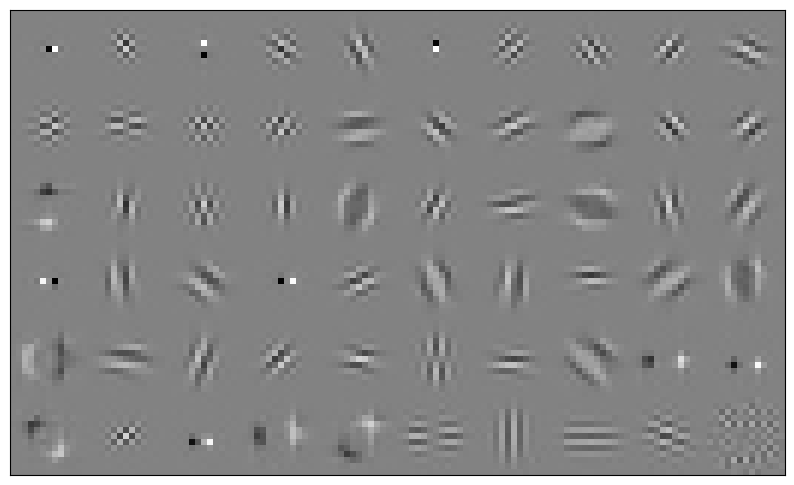

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(get_filter_image(normalize=True).detach().cpu(), cmap="gray")
plt.xticks([])
plt.yticks([])

2. Profile function

**** Updating integrated spline coefficients ****
**** Updating integrated spline coefficients ****


Text(0.5, 1.0, 'Activation function')

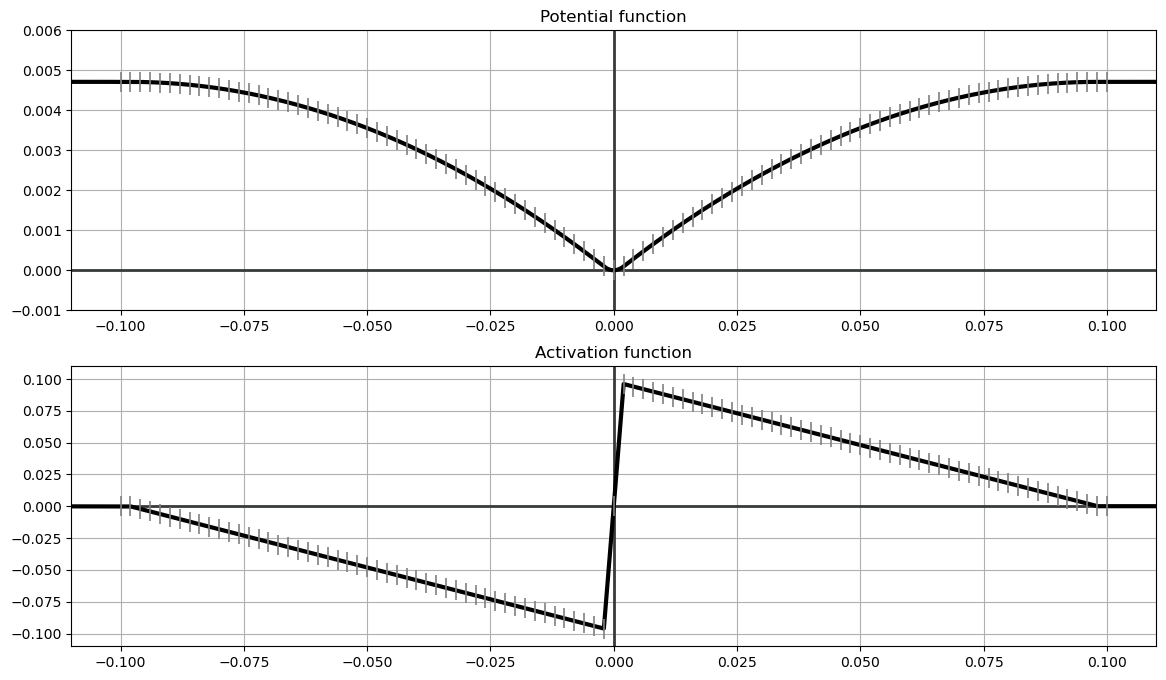

In [6]:
model.activation_cvx.hyper_param_to_device()
model.activation_cvx.hyper_param_to_device()
model.update_integrated_params()
x = torch.linspace(1.1*model.activation_cvx.x_min.item(), 1.1*model.activation_cvx.x_max.item(), 10000).to(device).view(1, 1, 1, -1)

xgrid = torch.linspace(model.activation_cvx.x_min.item(), model.activation_cvx.x_max.item(), model.activation_cvx.num_knots//2 + 1).to(device).view(1, 1, 1, -1)

xgrid = torch.linspace(model.activation_cvx.x_min.item(), model.activation_cvx.x_max.item(), model.activation_cvx.num_knots).to(device).view(1, 1, 1, -1)

col_l = [x/255 for x in [3, 0, 122]]
col_l="k"
ms = 200
lw = 4
lw = 3
mew = 1.2
mec = "gray"
mfc = "red"

plt.figure(figsize=(14,8))
sigma = 15
plt.subplot(2, 1, 1)
y = model.integrate_activation(x, sigma=torch.tensor([sigma], device=device).view(1,1,1,1), skip_scaling=True).squeeze().detach().cpu()

col = (55/255, 59/255, 56/255)

ygrid = model.integrate_activation(xgrid, sigma=torch.tensor([sigma], device=device).view(1,1,1,1), skip_scaling=True).squeeze().detach().cpu()

plt.plot([-0.2, 0.2], [0, 0], color=col, lw=2)
plt.plot([0, 0], [-0.1, 1], color=col, lw=2)
plt.plot(x.squeeze().detach().cpu(), y, color=col_l, lw=lw)

plt.scatter(xgrid.squeeze().detach().cpu(), ygrid, marker="|", s=ms, fc=mfc, ec=mec, zorder=10, lw=mew)

plt.grid()
plt.title("Potential function")

plt.xlim(-0.11, 0.11)
plt.ylim(-0.001, 0.006)
plt.subplot(2, 1, 2)

y = model.activation(x, sigma=torch.tensor([sigma], device=device).view(1,1,1,1), skip_scaling=True)

ygrid = model.activation(xgrid, sigma=torch.tensor([sigma], device=device).view(1,1,1,1), skip_scaling=True).squeeze().detach().cpu()

plt.plot([-0.2, 0.2], [0, 0], color=col, lw=2)
plt.plot([0, 0], [-0.15, 15], color=col, lw=2)
plt.scatter(xgrid.squeeze().detach().cpu(), ygrid, marker="|", s=ms, fc=mfc, ec=mec, zorder=10, lw=mew)
plt.plot(x.squeeze().detach().cpu(), y.squeeze().detach().cpu(), color=col_l, lw=lw)
plt.grid()
plt.xlim(-0.11, 0.11)
plt.ylim(-0.11, 0.11)

plt.title("Activation function")

